In [1]:
import sys
import os
from pathlib import Path

root_path = str(Path(os.getcwd()).parents[3])
sys.path.append(root_path)

In [2]:
import gymnasium as gym
import pandas as pd
import numpy as np

import tensorflow as tf
from mercury2.rl.agents import ImitationAgent

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

2024-07-02 16:28:05.525036: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 16:28:05.525077: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 16:28:05.526138: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-02 16:28:05.532874: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-02 16:28:06.334208: W tensorflow/compiler/tf2

# Download the Dataset

https://www.kaggle.com/datasets/gibrano/intel-historical-stock-price?resource=download&select=intel.csv

# Loading the dataset

In [3]:
data_path = root_path+"/data/intel.csv"

In [4]:
states_cols = ['change_ewm3','change_ewm7','change_ewm15','change_ewm30']
action_col = 'label'
reward_col = 'reward'
episode_col_id = 'episode_id'
order_col = 'seq'

In [5]:
df = pd.read_csv(data_path)

In [6]:
map_position = {'long':0, 'short':1}

df.label = df.label.map(map_position)

# Training

In [7]:
n = int(0.9*df.shape[0])
train, test = df[:n], df[n:]

In [35]:
batch_size = 1

agent = ImitationAgent(learning_rate=0.001, num_states=4, n_actions=2)

epochs = 1000
for epoch in range(epochs):    
    
    episodes = train.episode_id.unique()
    episodes = list(episodes)
    
    while len(episodes) > 0:

        episode_id = episodes.pop(0)

        df_batch = train[train.episode_id == episode_id].sort_values(by=["episode_id","seq"], ascending=True)

        curr_states = df_batch[states_cols].values
        actions = df_batch[action_col].values
        rewards = df_batch[reward_col].values

        for j in range(df_batch.shape[0]):
            agent.store_transition(curr_states[j], actions[j], rewards[j])

        # Training
        agent.learn()  

    print("Epoch:", epoch, "Loss:", agent.loss.numpy())

Epoch: 0 Loss: 0.1562112
Epoch: 1 Loss: 0.12813781
Epoch: 2 Loss: 0.1230064
Epoch: 3 Loss: 0.11916834
Epoch: 4 Loss: 0.11555001
Epoch: 5 Loss: 0.11169381
Epoch: 6 Loss: 0.10866351
Epoch: 7 Loss: 0.105622955
Epoch: 8 Loss: 0.10342332
Epoch: 9 Loss: 0.10008905
Epoch: 10 Loss: 0.097227395
Epoch: 11 Loss: 0.0944503
Epoch: 12 Loss: 0.09176299
Epoch: 13 Loss: 0.08988446
Epoch: 14 Loss: 0.087924875
Epoch: 15 Loss: 0.08653984
Epoch: 16 Loss: 0.084606074
Epoch: 17 Loss: 0.08291807
Epoch: 18 Loss: 0.08112649
Epoch: 19 Loss: 0.07989669
Epoch: 20 Loss: 0.07837994
Epoch: 21 Loss: 0.077376924
Epoch: 22 Loss: 0.07648762
Epoch: 23 Loss: 0.07641599
Epoch: 24 Loss: 0.07543036
Epoch: 25 Loss: 0.07493378
Epoch: 26 Loss: 0.07381197
Epoch: 27 Loss: 0.07367032
Epoch: 28 Loss: 0.07279361
Epoch: 29 Loss: 0.072422065
Epoch: 30 Loss: 0.072256096
Epoch: 31 Loss: 0.07209564
Epoch: 32 Loss: 0.071381986
Epoch: 33 Loss: 0.07169404
Epoch: 34 Loss: 0.07129391
Epoch: 35 Loss: 0.07100541
Epoch: 36 Loss: 0.07074811
Epoch:

In [36]:
agent.policy.save(root_path+'/models/offline_stock_trading_imitation_model.h5')

/home/gibran/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
env = gym.make('MountainCar-v0', render_mode="human")

In [38]:
agent2 = ImitationAgent(num_states=4, n_actions=2, deterministic=True)
agent2.policy = tf.keras.models.load_model(root_path+'/models/offline_stock_trading_imitation_model.h5')

# Evaluation

For the model evaluation we asume that we have 1 quantity of the stock.

In [136]:
states = test[states_cols].values
prices = test['Close'].values

In [137]:
initial_quantity = 0
initial_budget = 1000

In [138]:
current_quantity = initial_quantity
current_budget = initial_budget

# Sell and Buy strategy
units = 1

positions, portfolio_value = [], []
map_position_inv = {0:'long', 1: 'short'}

horizon = 120

for i in range(horizon):
    
    action = agent2.choose_action(states[i])

    if action == 0 and current_budget >= prices[i]*units: # Long position
        current_budget -= prices[i]*units
        current_quantity += units
    elif action == 1 and current_quantity > 0 : # Short position
        available_units = units if current_quantity >= units else current_quantity 
        current_budget += prices[i]*available_units
        current_quantity -= available_units
    print("actions:",action, "quantity:", current_quantity, "budget:", current_budget)
    positions.append(map_position_inv[action])
    portfolio_value.append(current_quantity * prices[i] + current_budget)

actions: 0 quantity: 1 budget: 965.5
actions: 0 quantity: 2 budget: 931.0400009155273
actions: 0 quantity: 3 budget: 897.6700019836426
actions: 0 quantity: 4 budget: 863.6500015258789
actions: 0 quantity: 5 budget: 830.0200004577637
actions: 0 quantity: 6 budget: 795.9200019836426
actions: 0 quantity: 7 budget: 761.560001373291
actions: 0 quantity: 8 budget: 727.0100021362305
actions: 0 quantity: 9 budget: 690.1800003051758
actions: 0 quantity: 10 budget: 654.4099998474121
actions: 0 quantity: 11 budget: 618.6100006103516
actions: 0 quantity: 12 budget: 584.2200012207031
actions: 0 quantity: 13 budget: 549.3500022888184
actions: 0 quantity: 14 budget: 514.2100028991699
actions: 0 quantity: 15 budget: 478.9800033569336
actions: 0 quantity: 16 budget: 443.9600028991699
actions: 0 quantity: 17 budget: 409.68000411987305
actions: 0 quantity: 18 budget: 375.00000381469727
actions: 0 quantity: 19 budget: 340.1100044250488
actions: 0 quantity: 20 budget: 304.43000411987305
actions: 0 quantity

In [139]:
units1 = initial_quantity + initial_budget/prices[0]
units2 = current_quantity + current_budget/prices[-1]
print("Initial Portfolio units:", units1)
print("Final Portfolio units:", units2)
print("Growth rate: {}%".format(round(100*(units2-units1)/units1,2)))

Initial Portfolio units: 28.985507246376812
Final Portfolio units: 31.2209908315468
Growth rate: 7.71%


In [144]:
value1 = portfolio_value[0]
value2 = portfolio_value[-1]
print("Initial Portfolio value:", value1)
print("Final Portfolio value:", value2)
print("Growth rate: {}%".format(round(100*(value2-value1)/value1,2)))

Initial Portfolio value: 1000.0
Final Portfolio value: 1346.8999862670898
Growth rate: 34.69%


In [141]:
prices = np.array(prices)[:horizon]
positions = np.array(positions)[:horizon]

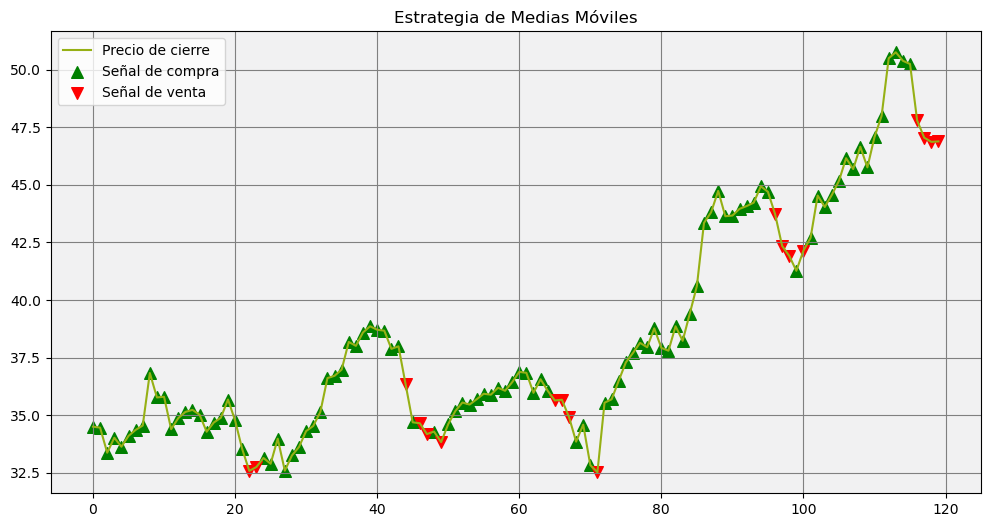

In [142]:
plt.figure(figsize=(12, 6))
plt.plot(prices, label='Precio de cierre', color='#96B015')
plt.scatter(np.where(positions == 'long'), prices[np.where(positions == 'long')],
            color='g',
            marker='^',
            s=70,
            label='Señal de compra')
plt.scatter(np.where(positions == 'short'), prices[np.where(positions == 'short')],
            color='red',
            marker='v',
            s=70,
            label='Señal de venta')
plt.legend()
plt.title('Estrategia de Medias Móviles')
# Agregar grid
plt.grid(color='gray')
# Agregar fondo
plt.gca().set_facecolor('#F1F1F2')
plt.show()